In [1]:
!pip install -q flwr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 11.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-api-core 1.34.1 wh

In [2]:
!pip install -U flwr

In [3]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import gc
import flwr as fl
from flwr.client import NumPyClient
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedProx
from flwr.simulation import run_simulation
import os

# --- Load and prepare data ---
data = np.load("/kaggle/input/daicwoz-balanced/dataset_balanced.npz")
X_audio_test = data["X_audio_test"]
X_text_test = data["X_text_test"]
y_test = data["y_test"]
X_audio_dev = data["X_audio_dev"]
X_text_dev = data["X_text_dev"]
y_dev = data["y_dev"]
X_audio_train = data["X_audio_train"]
X_text_train = data["X_text_train"]
y_train = data["y_train"]

y_train = y_train.reshape(-1, 1)
y_dev = y_dev.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# --- Parameters ---
NUM_CLIENTS = 10
input_shape_audio = (378, 60)
input_shape_text = (378, 9)

# --- Build model ---
def build_model():
    input_audio = layers.Input(shape=input_shape_audio, name='mfcc_input')
    x_audio = layers.LSTM(60, return_sequences=True, recurrent_dropout=0.002)(input_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(40, return_sequences=True, recurrent_dropout=0.002)(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)

    input_text = layers.Input(shape=input_shape_text, name='text_input')
    x_text = layers.Flatten()(input_text)

    x = layers.Concatenate()([x_audio, x_text])
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(2e-4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(15, activation='tanh')(x)
    x = layers.Dense(10, activation='tanh')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[input_audio, input_text], outputs=output)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
rmse.__name__ = "rmse"

def compile_model():
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-5),
                  loss=rmse,
                  metrics=['accuracy', 'mae', rmse])
    return model

# --- Split data across clients ---
def split_data(num_clients):
    size = len(y_train) // num_clients
    return [
        (X_audio_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         X_text_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         y_train[i * size : (i + 1) * size if i != num_clients - 1 else None])
        for i in range(num_clients)
    ]

client_datasets = split_data(NUM_CLIENTS)

# --- Client Definition ---
class DepressionClient(NumPyClient):
    def __init__(self, model, X_audio, X_text, y):
        self.model = model
        self.X_audio_train, self.X_audio_test, self.X_text_train, self.X_text_test, self.y_train, self.y_test = train_test_split(
            X_audio, X_text, y, test_size=0.1, random_state=42)

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit([self.X_audio_train, self.X_text_train], self.y_train,
                       batch_size=32, epochs=2, verbose=0, shuffle=True)
        return self.get_parameters(), len(self.y_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, acc, mae, rmse_val = self.model.evaluate([self.X_audio_test, self.X_text_test], self.y_test, verbose=0)
        return float(loss), len(self.y_test), {
            "accuracy": float(acc), "mae": float(mae), "rmse": float(rmse_val)}

# --- Client App ---
def client_fn(context: Context):
    partition_id = int(context.node_config.get("partition-id", 0))
    model = compile_model()
    X_audio_c, X_text_c, y_c = client_datasets[partition_id]
    return DepressionClient(model, X_audio_c, X_text_c, y_c).to_client()

client_app = fl.client.ClientApp(client_fn=client_fn)

# --- Compare multiple FedProx configurations ---
mu_values = [0.01, 0.1, 1.0]
results_by_mu = {}

for mu in mu_values:
    print(f"\n🚀 Starting FedProx with mu = {mu}")
    global_metrics = {"accuracy": [], "mae": [], "rmse": [], "f1_score": [], "precision": [], "recall": []}
    final_model_weights = {}

    def server_fn(context: Context):
        model = compile_model()

        def evaluate_fn(server_round, parameters, _config):
            model.set_weights(parameters)
            y_pred = model.predict([X_audio_dev, X_text_dev])
            y_pred_labels = (y_pred > 0.5).astype(int)

            acc = accuracy_score(y_dev, y_pred_labels)
            f1 = f1_score(y_dev, y_pred_labels)
            prec = precision_score(y_dev, y_pred_labels)
            rec = recall_score(y_dev, y_pred_labels)
            mae_val = np.mean(np.abs(y_dev - y_pred))
            rmse_val = np.sqrt(np.mean((y_dev - y_pred) ** 2))

            global_metrics["accuracy"].append(acc)
            global_metrics["mae"].append(mae_val)
            global_metrics["rmse"].append(rmse_val)
            global_metrics["f1_score"].append(f1)
            global_metrics["precision"].append(prec)
            global_metrics["recall"].append(rec)

            print(f"📊 [μ={mu}] Round {server_round}: Acc={acc:.4f}, F1={f1:.4f}, RMSE={rmse_val:.4f}")
            tf.keras.backend.clear_session()
            gc.collect()

            # Sauvegarde des derniers poids
            if server_round == 5:
                final_model_weights["weights"] = parameters

            return float(rmse_val), {
                "accuracy": float(acc),
                "f1_score": float(f1),
                "precision": float(prec),
                "recall": float(rec),
                "mae": float(mae_val),
                "rmse": float(rmse_val),
            }

        strategy = FedProx(
            fraction_fit=0.8,
            fraction_evaluate=0.5,
            min_fit_clients=NUM_CLIENTS,
            min_evaluate_clients=5,
            min_available_clients=NUM_CLIENTS,
            evaluate_fn=evaluate_fn,
            proximal_mu=mu,
        )
        return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=5))

    server_app = ServerApp(server_fn=server_fn)

    run_simulation(
        server_app=server_app,
        client_app=client_app,
        num_supernodes=NUM_CLIENTS,
        backend_config={"client_resources": {"num_cpus": 1, "num_gpus": 0.0}},
    )

    # --- Apply final weights and save the model ---
    final_model = compile_model()
    final_model.set_weights(final_model_weights["weights"])
    model_path = f"fedprox_model_mu_{mu}.h5"
    final_model.save(model_path)
    print(f"✅ Model saved to {model_path}")

    # --- Final Test Evaluation ---
    y_pred_test = final_model.predict([X_audio_test, X_text_test])
    y_pred_test_labels = (y_pred_test > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred_test_labels)
    f1 = f1_score(y_test, y_pred_test_labels)
    prec = precision_score(y_test, y_pred_test_labels)
    rec = recall_score(y_test, y_pred_test_labels)
    mae = np.mean(np.abs(y_test - y_pred_test))
    rmse_val = np.sqrt(np.mean((y_test - y_pred_test) ** 2))

    results_by_mu[mu] = global_metrics
    results_by_mu[mu]['test_final'] = {
        "accuracy": acc,
        "f1_score": f1,
        "precision": prec,
        "recall": rec,
        "mae": mae,
        "rmse": rmse_val,
    }

    print(f"\n✅ [μ={mu}] FINAL TEST — Acc={acc:.4f}, F1={f1:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, MAE={mae:.4f}, RMSE={rmse_val:.4f}")


2025-07-07 11:49:03.983368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751888944.216482      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751888944.282379      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



🚀 Starting FedProx with mu = 0.01


I0000 00:00:1751888972.743468     101 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751888972.744758     101 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=455) 2025-07-07 11:49:41.048828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=457) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=457) E0000 00:00:1751888981.099929     457 cuda_dnn.cc:8310] 

44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 604ms/step
📊 [μ=0.01] Round 0: Acc=0.5280, F1=0.5588, RMSE=0.5000


INFO :      initial parameters (loss, other metrics): 0.4999646842479706, {'accuracy': 0.5280172413793104, 'f1_score': 0.5587642713230356, 'precision': 0.5245901639344263, 'recall': 0.5977011494252874, 'mae': 0.49928274750709534, 'rmse': 0.4999646842479706}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=457) 2025-07-07 11:50:19.169612: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(ClientAppActor pid=455) 2025-07-07 11:50:19.176348: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 579ms/step
📊 [μ=0.01] Round 1: Acc=0.5057, F1=0.5383, RMSE=0.5001


INFO :      fit progress: (1, 0.5000594258308411, {'accuracy': 0.5057471264367817, 'f1_score': 0.5382550335570471, 'precision': 0.5050377833753149, 'recall': 0.5761494252873564, 'mae': 0.4991244673728943, 'rmse': 0.5000594258308411}, 328.76890510299995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 582ms/step
📊 [μ=0.01] Round 2: Acc=0.5108, F1=0.4477, RMSE=0.5004


INFO :      fit progress: (2, 0.5004227161407471, {'accuracy': 0.5107758620689655, 'f1_score': 0.4476885644768857, 'precision': 0.5139664804469274, 'recall': 0.39655172413793105, 'mae': 0.4989280700683594, 'rmse': 0.5004227161407471}, 678.540829069)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 588ms/step
📊 [μ=0.01] Round 3: Acc=0.5050, F1=0.4448, RMSE=0.5010


INFO :      fit progress: (3, 0.5010119080543518, {'accuracy': 0.5050287356321839, 'f1_score': 0.44480257856567285, 'precision': 0.5064220183486239, 'recall': 0.39655172413793105, 'mae': 0.4986777901649475, 'rmse': 0.5010119080543518}, 1007.7807508369999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 594ms/step
📊 [μ=0.01] Round 4: Acc=0.5007, F1=0.4336, RMSE=0.5019


INFO :      fit progress: (4, 0.5018523335456848, {'accuracy': 0.5007183908045977, 'f1_score': 0.43357783211083945, 'precision': 0.5009416195856874, 'recall': 0.382183908045977, 'mae': 0.4983346462249756, 'rmse': 0.5018523335456848}, 1341.8146489059998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 586ms/step
📊 [μ=0.01] Round 5: Acc=0.4986, F1=0.4250, RMSE=0.5030


INFO :      fit progress: (5, 0.5029948353767395, {'accuracy': 0.4985632183908046, 'f1_score': 0.4250411861614498, 'precision': 0.4980694980694981, 'recall': 0.3706896551724138, 'mae': 0.4978514015674591, 'rmse': 0.5029948353767395}, 1680.759296041)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 2596 MiB, 3 objects, write throughput 345 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=456) 2025-07-07 11:50:19.169197: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(raylet) Spilled 4328 MiB, 5 objects, write throughput 418 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1696.27s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.504702341556549
INFO :      		rou

✅ Model saved to fedprox_model_mu_0.01.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 636ms/step

✅ [μ=0.01] FINAL TEST — Acc=0.5036, F1=0.4294, Prec=0.5049, Rec=0.3736, MAE=0.5017, RMSE=0.5069

🚀 Starting FedProx with mu = 0.1


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=12008) 2025-07-07 12:19:14.119937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=12005) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=12005) E0000 00:00:1751890754.197018   12005 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=12005) E0000 00:00:1751890754.211230   12005 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=12006) 2025-07-07 12:19:20.660120: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 593ms/step
📊 [μ=0.1] Round 0: Acc=0.4799, F1=0.4017, RMSE=0.5011


INFO :      initial parameters (loss, other metrics): 0.5010610222816467, {'accuracy': 0.47988505747126436, 'f1_score': 0.40165289256198344, 'precision': 0.4727626459143969, 'recall': 0.34913793103448276, 'mae': 0.5008223056793213, 'rmse': 0.5010610222816467}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=12007) 2025-07-07 12:19:51.523302: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(ClientAppActor pid=12005) 2025-07-07 12:19:51.601259: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 576ms/step
📊 [μ=0.1] Round 1: Acc=0.4713, F1=0.3957, RMSE=0.5015


INFO :      fit progress: (1, 0.5014647841453552, {'accuracy': 0.47126436781609193, 'f1_score': 0.3957307060755336, 'precision': 0.4616858237547893, 'recall': 0.34626436781609193, 'mae': 0.5010526180267334, 'rmse': 0.5014647841453552}, 330.89071091799997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 576ms/step
📊 [μ=0.1] Round 2: Acc=0.4741, F1=0.4020, RMSE=0.5022


INFO :      fit progress: (2, 0.5021576285362244, {'accuracy': 0.47413793103448276, 'f1_score': 0.4019607843137255, 'precision': 0.4659090909090909, 'recall': 0.35344827586206895, 'mae': 0.5014544725418091, 'rmse': 0.5021576285362244}, 665.0229706109999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 577ms/step
📊 [μ=0.1] Round 3: Acc=0.4734, F1=0.4026, RMSE=0.5030


INFO :      fit progress: (3, 0.5030151009559631, {'accuracy': 0.4734195402298851, 'f1_score': 0.4026079869600652, 'precision': 0.4651600753295669, 'recall': 0.35488505747126436, 'mae': 0.5018492341041565, 'rmse': 0.5030151009559631}, 997.9621370269997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 2596 MiB, 3 objects, write throughput 351 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=12008) 2025-07-07 12:19:51.558136: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 582ms/step
📊 [μ=0.1] Round 4: Acc=0.4727, F1=0.3993, RMSE=0.5039


INFO :      fit progress: (4, 0.5038977265357971, {'accuracy': 0.47270114942528735, 'f1_score': 0.3993453355155483, 'precision': 0.46387832699619774, 'recall': 0.3505747126436782, 'mae': 0.5020189881324768, 'rmse': 0.5038977265357971}, 1329.0684382109994)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 5193 MiB, 6 objects, write throughput 381 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 576ms/step
📊 [μ=0.1] Round 5: Acc=0.4713, F1=0.3987, RMSE=0.5052


INFO :      fit progress: (5, 0.5051735043525696, {'accuracy': 0.47126436781609193, 'f1_score': 0.39869281045751637, 'precision': 0.4621212121212121, 'recall': 0.3505747126436782, 'mae': 0.5022332072257996, 'rmse': 0.5051735043525696}, 1677.4107983180002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1687.82s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5034619927406311
INFO :      		round 2: 0.5013473629951477
INFO :      		round 3: 0.5036133527755737
INFO :      		round 4: 0.5055433809757233
INFO :      		round 5: 0.5042364954948425
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5010610222816467
INFO :      		round 1: 0.5014647841453552
INFO :      		round 2: 0.5021576285362244
INFO :      		round 3: 0.5030151009559631
INFO :      		round 4: 0.5038977265357971
INFO :      		round 

✅ Model saved to fedprox_model_mu_0.1.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 573ms/step

✅ [μ=0.1] FINAL TEST — Acc=0.5180, F1=0.4549, Prec=0.5234, Rec=0.4023, MAE=0.4974, RMSE=0.4999

🚀 Starting FedProx with mu = 1.0


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=23620) 2025-07-07 12:48:33.825762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=23621) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=23621) E0000 00:00:1751892513.875818   23621 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=23621) E0000 00:00:1751892513.889586   23621 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=23623) 2025-07-07 12:48:39.905865: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 605ms/step
📊 [μ=1.0] Round 0: Acc=0.5050, F1=0.2770, RMSE=0.5003


INFO :      initial parameters (loss, other metrics): 0.5002927780151367, {'accuracy': 0.5050287356321839, 'f1_score': 0.27701993704092337, 'precision': 0.5136186770428015, 'recall': 0.1896551724137931, 'mae': 0.499440461397171, 'rmse': 0.5002927780151367}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23621) 2025-07-07 12:49:10.882118: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(ClientAppActor pid=23622) 2025-07-07 12:49:10.889571: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 584ms/step
📊 [μ=1.0] Round 1: Acc=0.5280, F1=0.4282, RMSE=0.4999


INFO :      fit progress: (1, 0.49992960691452026, {'accuracy': 0.5280172413793104, 'f1_score': 0.42819843342036557, 'precision': 0.543046357615894, 'recall': 0.35344827586206895, 'mae': 0.4990847408771515, 'rmse': 0.49992960691452026}, 322.1854362690001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 585ms/step
📊 [μ=1.0] Round 2: Acc=0.5043, F1=0.4092, RMSE=0.4999


INFO :      fit progress: (2, 0.499893456697464, {'accuracy': 0.5043103448275862, 'f1_score': 0.4092465753424658, 'precision': 0.5063559322033898, 'recall': 0.34339080459770116, 'mae': 0.49862706661224365, 'rmse': 0.499893456697464}, 648.2794585620004)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 585ms/step
📊 [μ=1.0] Round 3: Acc=0.5065, F1=0.4232, RMSE=0.5001


INFO :      fit progress: (3, 0.5001375079154968, {'accuracy': 0.5064655172413793, 'f1_score': 0.4231738035264484, 'precision': 0.509090909090909, 'recall': 0.3620689655172414, 'mae': 0.49809888005256653, 'rmse': 0.5001375079154968}, 987.3427986690003)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 583ms/step
📊 [μ=1.0] Round 4: Acc=0.5108, F1=0.4292, RMSE=0.5007


INFO :      fit progress: (4, 0.5007422566413879, {'accuracy': 0.5107758620689655, 'f1_score': 0.4291701592623638, 'precision': 0.5150905432595574, 'recall': 0.367816091954023, 'mae': 0.49755746126174927, 'rmse': 0.5007422566413879}, 1315.0897770050005)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 579ms/step
📊 [μ=1.0] Round 5: Acc=0.5108, F1=0.4292, RMSE=0.5019


INFO :      fit progress: (5, 0.5018793940544128, {'accuracy': 0.5107758620689655, 'f1_score': 0.4291701592623638, 'precision': 0.5150905432595574, 'recall': 0.367816091954023, 'mae': 0.4971280097961426, 'rmse': 0.5018793940544128}, 1648.6913226380002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1661.94s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.4981658816337585
INFO :      		round 2: 0.5004011392593384
INFO :      		round 3: 0.503843355178833
INFO :      		round 4: 0.49645299911499025
INFO :      		round 5: 0.4946603000164032
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5002927780151367
INFO :      		round 1: 0.49992960691452026
INFO :      		round 2: 0.499893456697464
INFO :      		round 3: 0.5001375079154968
INFO :      		round 4: 0.5007422566413879
INFO :      		round 5: 

✅ Model saved to fedprox_model_mu_1.0.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 611ms/step

✅ [μ=1.0] FINAL TEST — Acc=0.5194, F1=0.4574, Prec=0.5251, Rec=0.4052, MAE=0.4994, RMSE=0.5038



📊 Résultats finaux sur le test set :
μ = 0.01 — Accuracy = 0.5036, F1 = 0.4294, RMSE = 0.5069
μ = 0.1  — Accuracy = 0.5180, F1 = 0.4549, RMSE = 0.4999
μ = 1.0  — Accuracy = 0.5194, F1 = 0.4574, RMSE = 0.5038


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


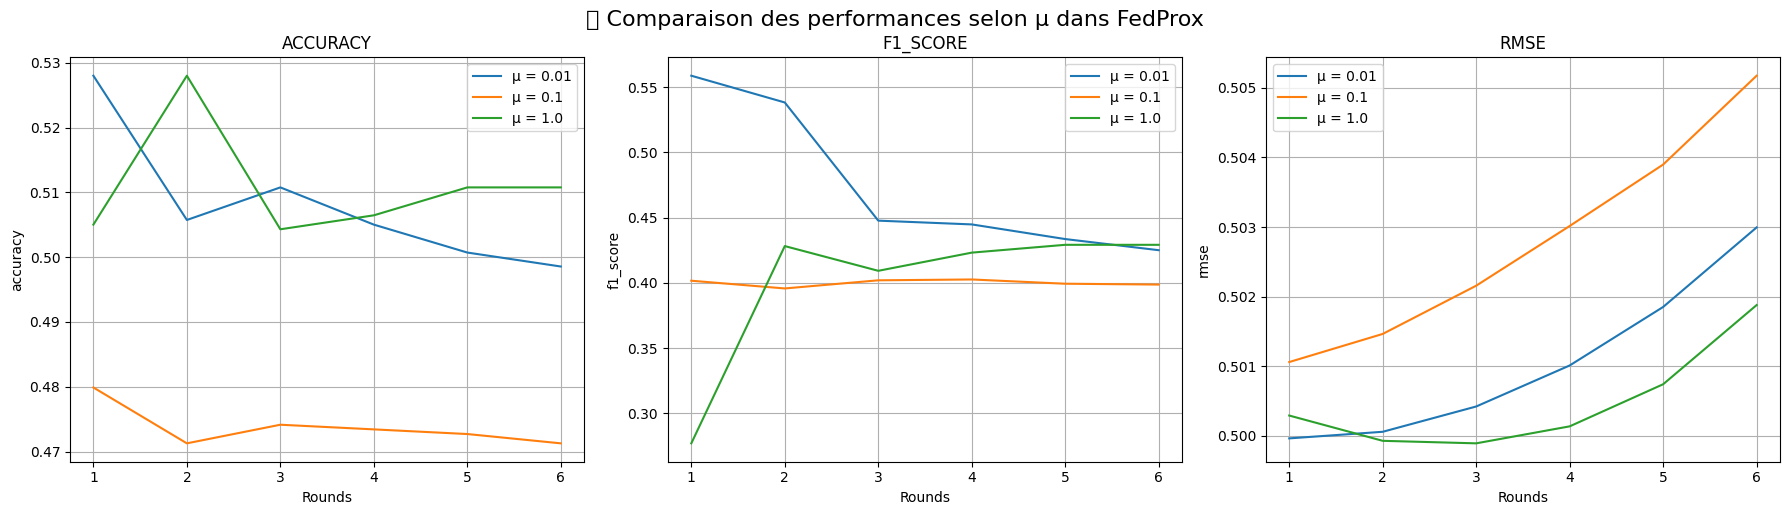

In [4]:
# --- Résumé des résultats finaux sur le jeu de test ---
print("\n📊 Résultats finaux sur le test set :")
for mu in mu_values:
    res = results_by_mu[mu]["test_final"]
    print(f"μ = {mu:<4} — Accuracy = {res['accuracy']:.4f}, F1 = {res['f1_score']:.4f}, RMSE = {res['rmse']:.4f}")

# --- Tracer les courbes d'évolution des métriques ---
import matplotlib.pyplot as plt

metrics_to_plot = ["accuracy", "f1_score", "rmse"]
plt.figure(figsize=(18, 5))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(1, len(metrics_to_plot), i)
    for mu in mu_values:
        rounds = range(1, len(results_by_mu[mu][metric]) + 1)
        plt.plot(rounds, results_by_mu[mu][metric], label=f"μ = {mu}")
    plt.title(metric.upper())
    plt.xlabel("Rounds")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle("📈 Comparaison des performances selon μ dans FedProx", fontsize=16, y=1.02)
plt.show()
